In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

df_spot = yf.download("SPY", start="2010-01-01", end="2025-04-24")
df_spot.to_csv("spy_spot_history.csv")
print("✅ Saved SPY spot history to spy_spot_history.csv")

ticker = yf.Ticker("SPY")
option_frames = []

for exp in ticker.options:
    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    calls["optionType"] = "call"
    calls["expiration"] = exp
    puts = chain.puts.copy()
    puts["optionType"] = "put"
    puts["expiration"] = exp
    option_frames.extend([calls, puts])

df_options = pd.concat(option_frames, ignore_index=True)
df_options.to_csv("spy_option_chain.csv", index=False)
print("✅ Saved SPY option chain to spy_option_chain.csv")

[*********************100%***********************]  1 of 1 completed


✅ Saved SPY spot history to spy_spot_history.csv
✅ Saved SPY option chain to spy_option_chain.csv


In [ ]:
!pip install pandas==2.2.2 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 91.1 MB/s eta 0:00:00


✅  IV imputation complete.
✅ 115 rows saved to vega_comparison_results.csv


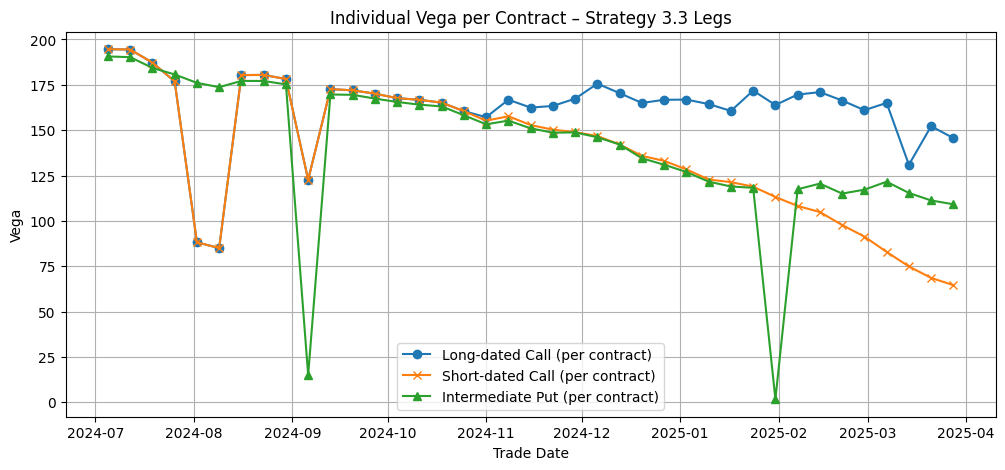

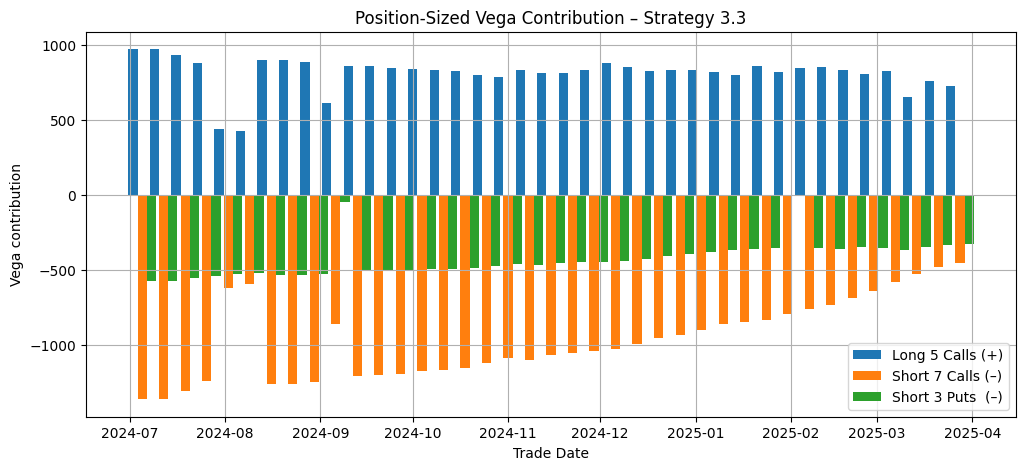

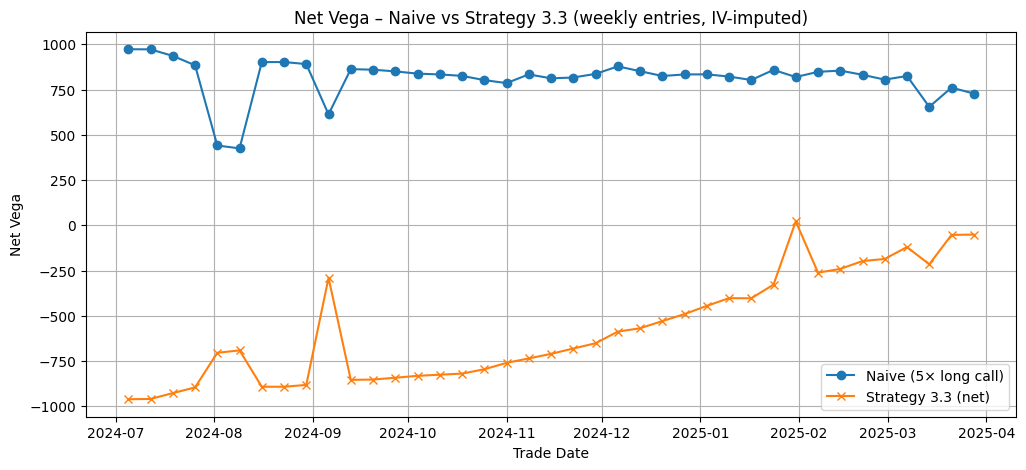

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import log, sqrt
from scipy.stats import norm

spot_df    = pd.read_csv("spy_spot_history.csv")
options_df = pd.read_csv("spy_option_chain.csv")

spot_df = (spot_df.rename(columns={"Date": "trade_date", "Close": "S0"})
                    .loc[:, ["trade_date", "S0"]])
spot_df["trade_date"] = pd.to_datetime(spot_df["trade_date"], dayfirst=True)
spot_df = spot_df.set_index("trade_date")

options_df["impliedVolatility"] = options_df["impliedVolatility"].astype(float)

realised_vol = (
    spot_df["S0"]
      .pct_change()
      .rolling(30).std()
      .mul(np.sqrt(252))
      .clip(lower=0.10, upper=0.40)
)


def impute_iv(row, min_iv=1e-4):
    iv = row.impliedVolatility
    if (iv > min_iv) and (not np.isnan(iv)):
        return iv
    exp = row.expiration
    typ = row.optionType
    peers = options_df[(options_df.expiration == exp) &
                       (options_df.optionType == typ) &
                       (options_df.impliedVolatility > min_iv)]
    if not peers.empty:
        return peers["impliedVolatility"].median()
    trade_dt = pd.to_datetime(exp, dayfirst=True) - pd.Timedelta(days=1)
    if trade_dt in realised_vol.index and not np.isnan(realised_vol.loc[trade_dt]):
        return realised_vol.loc[trade_dt]
    return 0.25

options_df["impliedVolatility"] = options_df.apply(impute_iv, axis=1)
print("✅  IV imputation complete.")

def bs_vega(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (log(S / K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * sqrt(T) * norm.pdf(d1)

def valid_iv(iv_val, min_iv=5e-4):
    return (iv_val > min_iv) and (not np.isnan(iv_val))

W_LONG, W_SCALL, W_SPUT = 5, -7, -3
r = 0.01

results = []
for trade_dt in pd.date_range("2023-01-06", "2025-04-01", freq="W-FRI"):
    if trade_dt not in spot_df.index:
        continue
    S0 = spot_df.loc[trade_dt, "S0"]

    def pick_exp(offset):
        tgt  = trade_dt + pd.Timedelta(days=offset)
        exps = sorted(options_df["expiration"].unique())
        fut  = [pd.to_datetime(e, dayfirst=True) for e in exps
                if pd.to_datetime(e, dayfirst=True) >= tgt]
        return min(fut, key=lambda d: (d - tgt).days) if fut else None

    exp_short = pick_exp(30)
    exp_inter = pick_exp(90)
    exp_long  = pick_exp(180)
    if not (exp_short and exp_inter and exp_long):
        continue

    cs = options_df[(options_df.expiration == exp_short.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "call")]
    if cs.empty: continue
    strike_sc = cs.loc[(cs.strike - S0).abs().idxmin(), "strike"]
    iv_sc = cs.loc[cs.strike == strike_sc, "impliedVolatility"].values[0]
    if not valid_iv(iv_sc): continue
    vega_sc = bs_vega(S0, strike_sc, r, iv_sc, (exp_short - trade_dt).days/365)

    ps = options_df[(options_df.expiration == exp_inter.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "put") & (options_df.strike < S0)]
    ps = ps.sort_values("strike", ascending=False)
    strike_sp = iv_sp = vega_sp = None
    for _, row in ps.iterrows():
        if valid_iv(row.impliedVolatility):
            strike_sp = row.strike
            iv_sp     = row.impliedVolatility
            vega_sp   = bs_vega(S0, strike_sp, r, iv_sp,
                                (exp_inter - trade_dt).days/365)
            break
    if vega_sp is None: continue

    cl = options_df[(options_df.expiration == exp_long.strftime("%d-%m-%Y")) &
                    (options_df.optionType == "call")]
    strike_lc = cl.loc[(cl.strike - S0).abs().idxmin(), "strike"]
    iv_lc = cl.loc[cl.strike == strike_lc, "impliedVolatility"].values[0]
    if not valid_iv(iv_lc): continue
    vega_lc = bs_vega(S0, strike_lc, r, iv_lc, (exp_long - trade_dt).days/365)

    naive_vega    = W_LONG * vega_lc
    strategy_vega = W_LONG*vega_lc + W_SCALL*vega_sc + W_SPUT*vega_sp

    results.append({
        "trade_date": trade_dt,
        "S0": S0,
        "vega_long_call":  vega_lc,
        "vega_short_call": vega_sc,
        "vega_short_put":  vega_sp,
        "naive_vega":     naive_vega,
        "strategy_vega":  strategy_vega
    })

if not results:
    print("No trades passed filters — relax IV threshold or widen date range.")
else:
    vega_df = pd.DataFrame(results).set_index("trade_date").sort_index()
    vega_df.to_csv("vega_comparison_results.csv")
    print(f"✅ {len(vega_df)} rows saved to vega_comparison_results.csv")
    plot_df = vega_df.loc["2024-07":"2025-04"]

    plt.figure(figsize=(12,5))
    plt.plot(plot_df.index, plot_df["vega_long_call"],  marker="o",
             label="Long-dated Call (per contract)")
    plt.plot(plot_df.index, plot_df["vega_short_call"], marker="x",
             label="Short-dated Call (per contract)")
    plt.plot(plot_df.index, plot_df["vega_short_put"],  marker="^",
             label="Intermediate Put (per contract)")
    plt.title("Individual Vega per Contract – Strategy 3.3 Legs")
    plt.xlabel("Trade Date"); plt.ylabel("Vega"); plt.legend(); plt.grid(True); plt.show()

    bw = np.timedelta64(3,"D")
    plt.figure(figsize=(12,5))
    plt.bar(plot_df.index-bw, W_LONG * plot_df["vega_long_call"],  width=bw,
            label="Long 5 Calls (+)",  color="
    plt.bar(plot_df.index,     W_SCALL*plot_df["vega_short_call"], width=bw,
            label="Short 7 Calls (–)", color="
    plt.bar(plot_df.index+bw,  W_SPUT * plot_df["vega_short_put"], width=bw,
            label="Short 3 Puts  (–)", color="
    plt.title("Position-Sized Vega Contribution – Strategy 3.3")
    plt.xlabel("Trade Date"); plt.ylabel("Vega contribution")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(plot_df.index, plot_df["naive_vega"],    marker="o", label="Naive (5× long call)")
    plt.plot(plot_df.index, plot_df["strategy_vega"], marker="x", label="Strategy 3.3 (net)")
    plt.title("Net Vega – Naive vs Strategy 3.3 (weekly entries, IV-imputed)")
    plt.xlabel("Trade Date"); plt.ylabel("Net Vega")
    plt.legend(); plt.grid(True); plt.show()

=== spot head ===
Date
2024-07-01    540.223633
2024-07-02    543.859192
2024-07-03    546.286255
2024-07-05    549.436340
2024-07-08    550.070374
Name: Close, dtype: float64 

Average 30-day ATM-call Vega: 6586.49

Chosen expiries: 2025-05-23 2025-07-31 2025-09-30 

Per-contract Vegas   LC:14188.8  SC:5908.0  SP:11004.1

Best combo (qLC,qSC,qSP) = (10, -8, -8)   → net Vega ≈ 6591.55


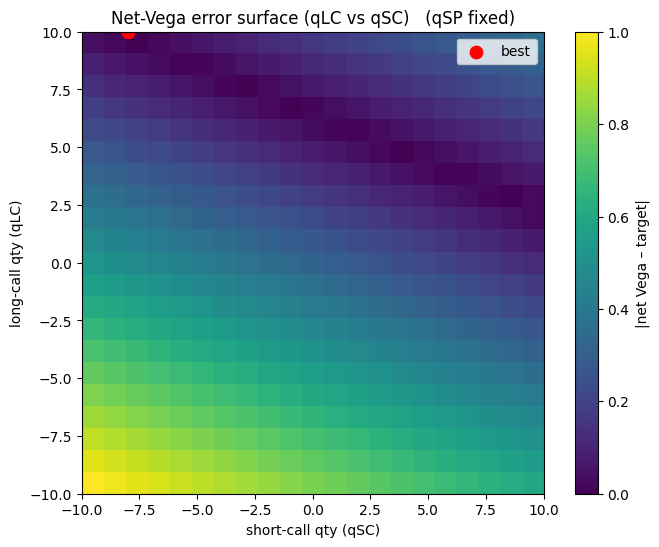

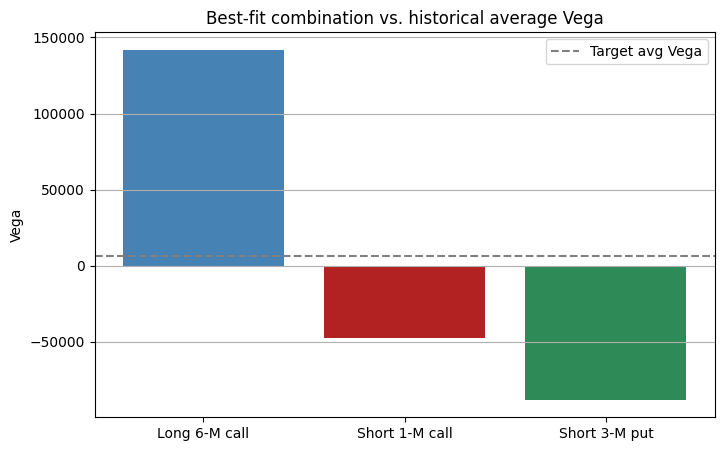

In [ ]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
import itertools, datetime as dt

TICKER = "SPY"
START  = "2024-07-01"
END    = "2025-04-25"
RF     = 0.01
MAX_Q  = 10

def bs_vega(S, K, r, sigma, T):
    if T <= 0 or sigma <= 0: return 0
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))
    return S * sqrt(T) * norm.pdf(d1)

tkr  = yf.Ticker(TICKER)
spot = tkr.history(start=START, end=END)["Close"]
spot.index = spot.index.tz_localize(None)
print("=== spot head ==="); print(spot.head(), "\n")

rv   = spot.pct_change().rolling(30).std()*np.sqrt(252)
vega_series=[]
for d in pd.date_range(START, END, freq="W-FRI"):
    if d not in spot.index or pd.isna(rv.get(d)): continue
    S  = spot.loc[d]; sigma = rv.loc[d]
    vega_series.append(bs_vega(S, S, RF, sigma, 30/365)*100)
avg_vega = np.mean(vega_series)
print(f"Average 30-day ATM-call Vega: {avg_vega:.2f}\n")

today = dt.date.today()
expiries = sorted(pd.to_datetime(tkr.options))
pick = lambda offset: min(expiries,
                          key=lambda e: abs((e.date()-today)-dt.timedelta(days=offset)))
exp_short, exp_inter, exp_long = map(pick, (30, 90, 180))
print("Chosen expiries:",
      exp_short.date(), exp_inter.date(), exp_long.date(), "\n")

S0_now = spot.iloc[-1]
atm_strk = round(S0_now/5)*5
otm_put  = atm_strk - 5

def leg_vega(exp, strike, kind):
    chain = tkr.option_chain(exp.strftime("%Y-%m-%d"))
    tbl   = chain.calls if kind=="call" else chain.puts
    row   = tbl[tbl.strike==strike]
    if row.empty: return None
    iv = max(row.impliedVolatility.values[0], 0.25)
    T  = (exp.date()-today).days/365
    return bs_vega(S0_now, strike, RF, iv, T)*100

vega_lc = leg_vega(exp_long,  atm_strk, "call")
vega_sc = leg_vega(exp_short, atm_strk, "call")
vega_sp = leg_vega(exp_inter, otm_put,  "put")

if None in (vega_lc, vega_sc, vega_sp):
    raise ValueError("Chosen strikes missing; adjust strike rounding.")

print(f"Per-contract Vegas   LC:{vega_lc:.1f}  SC:{vega_sc:.1f}  SP:{vega_sp:.1f}\n")

grid = range(-MAX_Q, MAX_Q+1)
best_combo, best_err = None, float("inf")
for q_lc, q_sc, q_sp in itertools.product(grid, repeat=3):
    net = q_lc*vega_lc + q_sc*vega_sc + q_sp*vega_sp
    err = abs(net - avg_vega)
    if err < best_err:
        best_err, best_combo = err, (q_lc, q_sc, q_sp)

q_lc, q_sc, q_sp = best_combo
net_best = q_lc*vega_lc + q_sc*vega_sc + q_sp*vega_sp
print(f"Best combo (qLC,qSC,qSP) = {best_combo}   → net Vega ≈ {net_best:.2f}")

err = np.zeros((2*MAX_Q+1,2*MAX_Q+1))
for i,q1 in enumerate(grid):
    for j,q2 in enumerate(grid):
        err[i,j] = abs(q1*vega_lc + q2*vega_sc + q_sp*vega_sp - avg_vega)

plt.figure(figsize=(8,6))
plt.imshow(err, origin="lower",
           extent=[-MAX_Q,MAX_Q,-MAX_Q,MAX_Q], cmap="viridis")
plt.scatter(q_sc, q_lc, c="red", s=80, label="best")
plt.colorbar(label="|net Vega – target|")
plt.title("Net-Vega error surface (qLC vs qSC)   (qSP fixed)")
plt.xlabel("short-call qty (qSC)"); plt.ylabel("long-call qty (qLC)")
plt.legend(); plt.show()

labels = ["Long 6-M call", "Short 1-M call", "Short 3-M put"]
vegas  = [q_lc*vega_lc, q_sc*vega_sc, q_sp*vega_sp]
plt.figure(figsize=(8,5))
plt.bar(labels, vegas, color=["steelblue","firebrick","seagreen"])
plt.axhline(avg_vega, color="gray", linestyle="--", label="Target avg Vega")
plt.title("Best-fit combination vs. historical average Vega")
plt.ylabel("Vega"); plt.legend(); plt.grid(axis="y"); plt.show()